<a href="https://colab.research.google.com/github/Pavel-V/Adaptive_Forecasting/blob/master/Wind_speed_NN_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Подготовка среды, данных, метрик

### 1.1 Установка и подключение нужных библиотек (пакетов)

In [0]:
# Установка пакета MPLD3 для добавления интерактивного функционала графикам
import sys
!{sys.executable} -m pip install mpld3

    100% |████████████████████████████████| 798kB 27.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


In [0]:
 # для чтения csv файла
import pandas as pd
import io

# для работы с нейронными сетям
import tensorflow as tf

# для быстрой обработки массивов данных
import numpy as np

# для загрузки данных с удаленного сервера
import requests

# для построения графиков
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
mpld3.enable_notebook()

### 1.2. Получение данных о скорости ветра 

In [0]:
url = "https://www.dropbox.com/s/jtgrei588ow7zpy/WindSpeed.csv?dl=1"
content = requests.get(url).content
input_df = pd.read_csv(io.StringIO(content.decode('utf-8')))

In [0]:
# Скорости ветра записывались каждые три часа.
# Для увеличения выборки данных и прогнозирования на 1 час вперед
# применена интерполяция, между каждыми отсчетами исходного набора данных 
# вставлено по два дополнительных часа, например, в файле данные о 10-м и 13-м часах,
# будут сгенерированы и добавлены данные за 11-й и 12-й час

input_arr = input_df.values
input_arr = np.squeeze(input_arr)

# временный массив для записи расширенных данных
tmp = np.zeros(3 * len(input_arr))

# установка начального значения генератора случайных чисел для получения стабильных результатов
np.random.seed(1)

j = 0
for i in range(0, len(input_arr) - 1):
     # 0-й, 3-й, 6-й, ...  часы как есть
    tmp[j] = input_arr[i]
    
    # 1-й, 4-й, 7-й часы путем интерполяции со случайным искажением (добавлением +.- 10%)
    tmp[j + 1] = (input_arr[i] + (1 * (input_arr[i + 1] - input_arr[i + 1]) / 3)) * np.random.uniform(0.9, 1.1)

    # 2-й, 5-й, 8-й часы путем интерполяции со случайным искажением  (добавлением +.- 10%)
    tmp[j + 2] = (input_arr[i] + (2 * (input_arr[i] - input_arr[i + 1]) / 3)) * np.random.uniform(0.9, 1.1)
    
    j += 3

# вывод размерности полученных массивов
print(input_arr.shape)
print(tmp.shape)

# чтобы данных стало ровно в три раза больше, последний час исходных данных просто
# со случайным искажением  (добавлением +.- 10%)
tmp[-3] = input_arr[-1] * np.random.uniform(0.9, 1.1)
tmp[-2] = input_arr[-1] * np.random.uniform(0.9, 1.1)
tmp[-1] = input_arr[-1] * np.random.uniform(0.9, 1.1)

input_arr = tmp

(975,)
(2925,)


![data_augmentation](https://www.dropbox.com/s/rlgt0i4ctd1illk/data_augmentation.jpg?dl=1 =366x155)

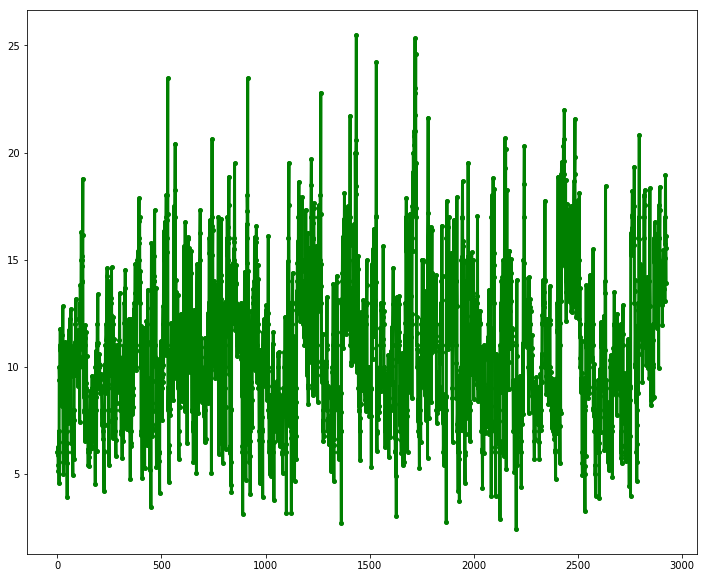

In [0]:
# вывод полученных данных за каждый час на графике
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(np.arange(len(input_arr)), input_arr, color = 'g', linewidth = 3, markersize = 4,  marker='o')
plt.show()

### 1.3. Разделение данных
Разделение на train (для обучения) и validation (для проверки качества).

In [0]:
# 2/3 на обучение
# 1/3 на валидацию
train_speed = input_arr[0 : 2 * len(input_arr) // 3]
val_speed = input_arr[2 * len(input_arr) // 3 : ]

train_speed = train_speed.reshape(train_speed.shape[0], 1)
val_speed = val_speed.reshape(val_speed.shape[0], 1)

print(train_speed.shape)
print(val_speed.shape)

(1950, 1)
(975, 1)


In [0]:
# Масштабирование данных - для нейронных сетей предпочитетельно чтобы входные данные были нормализованы от 0 до 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_speed)
train_speed_norm = scaler.transform(train_speed)
val_speed_norm = scaler.transform(val_speed)

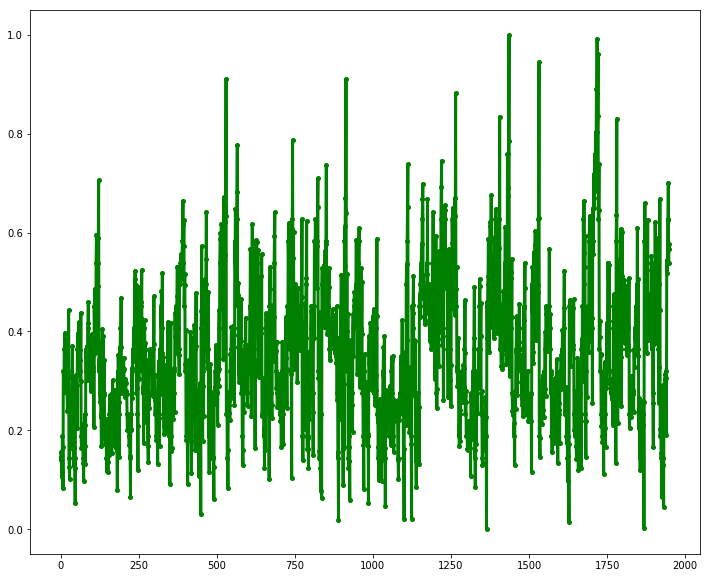

In [0]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(np.arange(len(train_speed_norm)), train_speed_norm, color = 'g', linewidth = 3, markersize = 4,  marker='o')
plt.show()

In [0]:
# Подготовка данных для обучения и тестирования
window_width = 12 # прогноз на час вперед по window_width предыдущим часам

def timeseries_to_matrix(input_ts, window_width):
  X = np.zeros((input_ts.shape[0] - window_width, window_width))
  y = np.zeros((input_ts.shape[0] - window_width, 1))

  for i in range(0, input_ts.shape[0] - window_width):
    y[i] = input_ts[i + window_width]
    for j in range(0, window_width):
      X[i][j] = input_ts[i + j]
  
  return (X, y)

X_train, y_train = timeseries_to_matrix(train_speed_norm, window_width)
X_val, y_val = timeseries_to_matrix(val_speed_norm, window_width)

### 1.4 Метрики для оценки качества прогнозов

In [0]:
# MSE - средний квадрат ошибки
def mse_calc(y_arr, f_arr):
    return ((y_arr - f_arr)**2).mean(axis = None)

# RMSEA - корень из среднего квадрата ошибки  
def rmse_calc(y_arr, f_arr):
    return np.sqrt(mse_calc(y_arr, f_arr))

# MAPE - среднее абсолютное значение ошибки в процентах  
def mape_calc(y_arr, f_arr):
    return (np.abs(y_arr - f_arr) / np.abs(y_arr)).mean(axis = None) * 100.


def print_metrics(train_ground_truth, val_ground_truth, train_forecast, val_forecast):
    print(("RMSE train = " + str(rmse_calc(train_ground_truth, train_forecast)) + "; MAPE train = " + str(mape_calc(train_ground_truth, train_forecast))))
    print(("RMSE val = "   + str(rmse_calc(val_ground_truth  , val_forecast))   + "; MAPE val = "   + str(mape_calc(val_ground_truth  , val_forecast))))

## 2. Алгоритмы прогнозирования и их применение

### 2.1. Построение, обучение и применение простой нейронной сети

In [0]:
# Плейсхолдеры
X = tf.placeholder(dtype=tf.float32, shape=[None, window_width], name='X')
y = tf.placeholder(dtype=tf.float32, shape=[None, 1], name='y')

# Инициализаторы
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode = "fan_avg", distribution = "uniform", scale = sigma)
bias_initializer = tf.zeros_initializer()

# Архитектуры сети
n_neurons_1 = 16
n_neurons_2 = 8
n_target = 1

W_hidden_1 = tf.Variable(weight_initializer([window_width, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

W_out = tf.Variable(weight_initializer([n_neurons_2, n_target]))
bias_out = tf.Variable(bias_initializer([n_target]))

hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))

out = (tf.add(tf.matmul(hidden_2, W_out), bias_out))

In [0]:
# Функция стоимости
mse = tf.reduce_mean(tf.squared_difference(out, y))

# Оптимизатор
opt = tf.train.AdamOptimizer().minimize(mse)

In [0]:
# установка начальных значений генераторов случайных чисел для получения стабильных результатов
tf.random.set_random_seed(1)
np.random.seed(1)

# Создание сессии
net = tf.Session()
# Запуск инициализатора
net.run(tf.global_variables_initializer())

epochs = 100
batch_size = 128

for e in range(epochs):

    # Перемешивание данных для обучения
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train_shuf = X_train[shuffle_indices]
    y_train_shuf = y_train[shuffle_indices]

    # Пакетное обучение
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train_shuf[start:start + batch_size]
        batch_y = y_train_shuf[start:start + batch_size]
                
        net.run(opt, feed_dict={X: batch_x, y: batch_y})
        
    #print((e, net.run(mse, feed_dict={X: batch_x, y: batch_y})))
            
# Вывести финальную фукнцию MSE после обучения
print(net.run(mse, feed_dict={X: X_train, y: y_train}))


mse_final = net.run(mse, feed_dict={X: X_val, y: y_val})
print(mse_final)

y_val_hat = net.run(out, feed_dict={X: X_val, y: y_val})

y_train_hat = net.run(out, feed_dict={X:X_train, y: y_train})


0.00899185
0.008730666


## 2.2. Вывод результатов и оценка по метрикам

RMSE train = 1.680190534136848; MAPE train = 13.069071569670946
RMSE val = 1.7878314228066177; MAPE val = 13.897215431305993


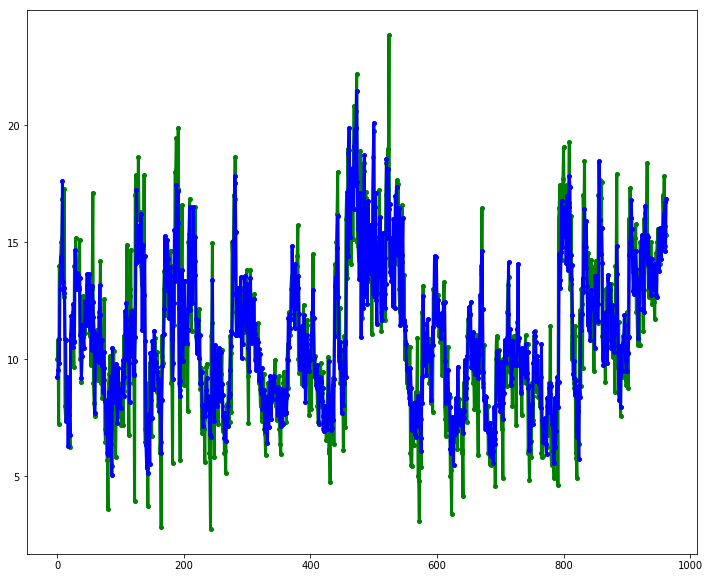

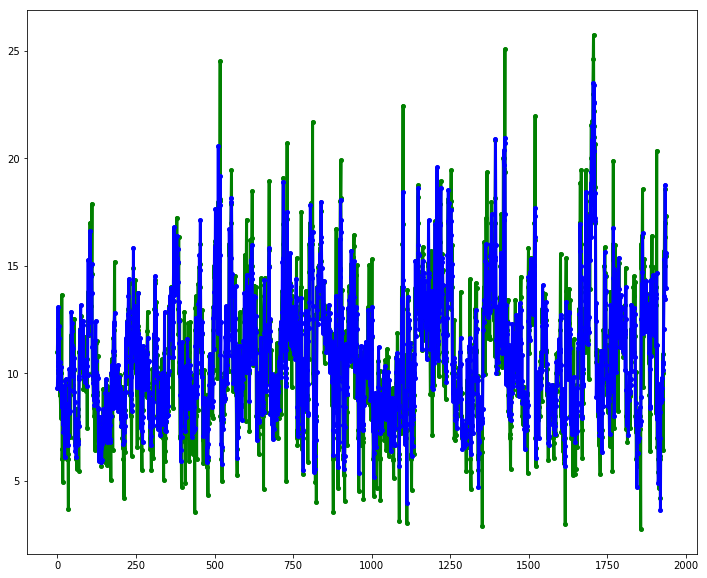

In [0]:
# Обратное преобразоние нормализованных данных
y_val_nn   = scaler.inverse_transform(y_val_hat)
y_train_nn = scaler.inverse_transform(y_train_hat)

print_metrics(train_speed[window_width:], val_speed[window_width:], y_train_nn, y_val_nn)

plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(np.arange(len(val_speed) - window_width), val_speed[window_width:]   , color = 'g', linewidth = 3, markersize = 4,  marker='o')
plt.plot(np.arange(len(val_speed) - window_width), y_val_nn, color = 'b', linewidth = 3, markersize = 4,  marker='o')

plt.show()


plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(np.arange(len(train_speed) - window_width), train_speed[window_width:]   , color = 'g', linewidth = 3, markersize = 4,  marker='o')
plt.plot(np.arange(len(train_speed) - window_width), y_train_nn, color = 'b', linewidth = 3, markersize = 4,  marker='o')

plt.show()